Mean Squared Error (MSE): 5.544394352784193
Mean Absolute Error (MAE): 1.492246699520903
R² Score: 0.9858887684920136


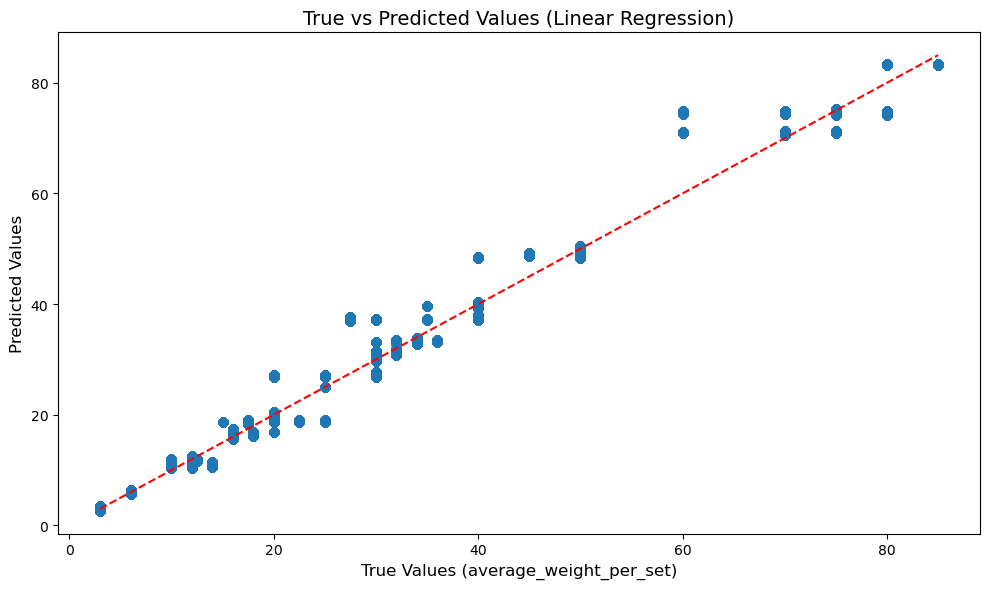

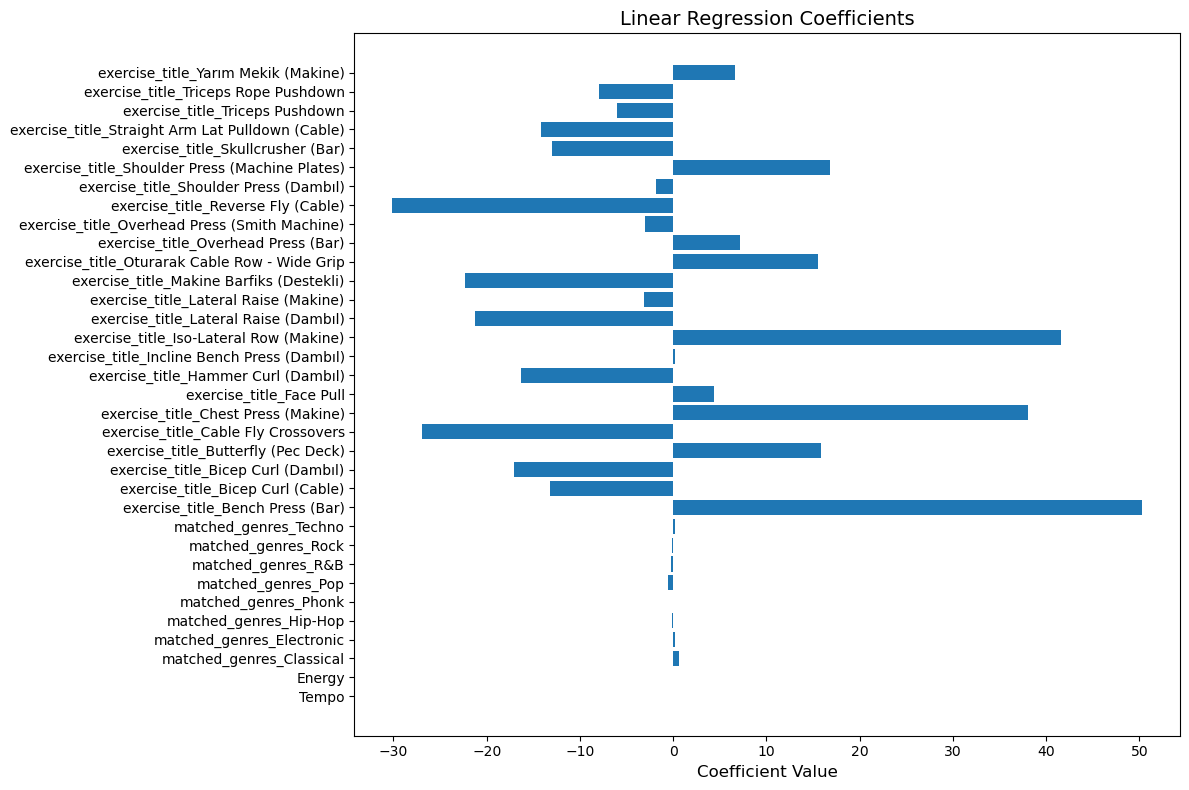

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Step 1: Load Data
# Load the workout data and music data
workout_data = pd.read_csv('/Users/cagdaskahraman/Dsa_210/workout_data.csv')
music_data = pd.read_csv('/Users/cagdaskahraman/Dsa_210/music_spoti.csv')

# Replace Turkish months with English and preprocess date columns
turkish_to_english_months = {
    'Oca': 'Jan', 'Şub': 'Feb', 'Mar': 'Mar', 'Nis': 'Apr', 'May': 'May', 'Haz': 'Jun',
    'Tem': 'Jul', 'Ağu': 'Aug', 'Eyl': 'Sep', 'Eki': 'Oct', 'Kas': 'Nov', 'Ara': 'Dec'
}
workout_data['start_time'] = workout_data['start_time'].replace(turkish_to_english_months, regex=True)
workout_data['end_time'] = workout_data['end_time'].replace(turkish_to_english_months, regex=True)
workout_data['start_time'] = pd.to_datetime(workout_data['start_time'], format='%d %b %Y, %H:%M', errors='coerce')
workout_data['end_time'] = pd.to_datetime(workout_data['end_time'], format='%d %b %Y, %H:%M', errors='coerce')
music_data['Start Time'] = pd.to_datetime(music_data['Start Time'])
music_data['End Time'] = pd.to_datetime(music_data['End Time'])

# Match music genres with workouts
matched_genres = []
for _, workout_row in workout_data.iterrows():
    overlapping_music = music_data[
        (music_data['Start Time'] <= workout_row['end_time']) &
        (music_data['End Time'] >= workout_row['start_time'])
    ]
    genres = overlapping_music['Genre'].tolist()
    matched_genres.append(genres)
workout_data['matched_genres'] = matched_genres

# Calculate total weight and clean data
workout_data['total_weight'] = workout_data['weight_kg'] * workout_data['reps']
cleaned_workout_data = workout_data.dropna(subset=['weight_kg', 'reps', 'total_weight'])
cleaned_workout_data = cleaned_workout_data[
    (cleaned_workout_data['weight_kg'] > 0) &
    (cleaned_workout_data['reps'] > 0) &
    (cleaned_workout_data['total_weight'] > 0)
]
cleaned_workout_data['average_weight_per_set'] = cleaned_workout_data['total_weight'] / cleaned_workout_data['reps']

# Merge music data into the workout data based on the matched genres
music_features = music_data[['Genre', 'Tempo', 'Energy']].drop_duplicates()
music_features.rename(columns={'Genre': 'matched_genres'}, inplace=True)
cleaned_workout_data = cleaned_workout_data.explode('matched_genres')
merged_data = pd.merge(cleaned_workout_data, music_features, on='matched_genres', how='inner')

# Step 2: Prepare Data for Machine Learning
# Select features and target variable
data_ml = merged_data[['matched_genres', 'Tempo', 'Energy', 'exercise_title', 'average_weight_per_set']]
data_ml = data_ml.dropna()

# Features (X) and Target (y)
X = data_ml[['matched_genres', 'Tempo', 'Energy', 'exercise_title']]
y = data_ml['average_weight_per_set']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define Preprocessing and Modeling Pipeline
# Preprocessor for scaling numeric features and encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Tempo', 'Energy']),
        ('cat', OneHotEncoder(), ['matched_genres', 'exercise_title'])
    ])

# Linear Regression Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Step 4: Train the Model
model.fit(X_train, y_train)

# Step 5: Evaluate the Model
# Predictions
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print Results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

# Step 6: Visualization of Results
# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('True vs Predicted Values (Linear Regression)', fontsize=14)
plt.xlabel('True Values (average_weight_per_set)', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.tight_layout()
plt.show()

# Coefficients Analysis
coefficients = model.named_steps['regressor'].coef_
feature_names = (
    model.named_steps['preprocessor']
    .transformers_[1][1]  # Get OneHotEncoder
    .get_feature_names_out(['matched_genres', 'exercise_title'])
)
feature_names = ['Tempo', 'Energy'] + list(feature_names)

# Plot coefficients
plt.figure(figsize=(12, 8))
plt.barh(feature_names, coefficients)
plt.title('Linear Regression Coefficients', fontsize=14)
plt.xlabel('Coefficient Value', fontsize=12)
plt.tight_layout()
plt.show()
